# An In-Depth View of Ford GoBike User Data
## by Elizabeth Blank

## Investigation Overview

The goal of this analysis is to identify which features of GoBike users best predict ride frequency.

## Dataset Overview

The dataset contains 1,863,721 survey responses regarding 16 trip attributes. Variables of interest include member gender (categorical), start time (object), member birth year (integer), user type (member or customer, categorical), and Bike Share for All membership status (categorical). The initial 1,863,721 observations was cut down to 1,670,060 after cleaning.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import os
import datetime
import statistics

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
path = r'C:\Users\lblank\Documents\Personal\Data Analyst Nanodegree\GoBike_DataVis\data'
files = glob.glob(os.path.join(path, '*.csv'))
clean = pd.concat((pd.read_csv(f) for f in files), ignore_index = True)

In [4]:
# remove NAs
clean.dropna(axis=0,inplace=True)

In [5]:
# create age variable and remove any outliers
clean['member_birth_year']= clean.member_birth_year.astype(str).str[:-2].astype(int)
clean['age'] = 2019-clean.member_birth_year
clean.loc[clean['member_birth_year']==1886, 'member_birth_year'] = 1986
clean.loc[clean['member_birth_year']==1900, 'member_birth_year'] = 2000
clean.drop(clean[clean['age']>61].index, inplace=True)

In [6]:
# change data types, tidy start_time variable (break into multiple variables)
clean.member_gender = clean.member_gender.astype('category')
clean.bike_share_for_all_trip = clean.bike_share_for_all_trip.astype('category')
clean.user_type = clean.user_type.astype('category')
clean.bike_id = clean.bike_id.astype(str)
clean.start_time = pd.to_datetime(clean.start_time)
clean.end_time = pd.to_datetime(clean.end_time)
clean['month'] = clean['start_time'].dt.strftime('%B')
clean['start_day'] = clean['start_time'].dt.strftime('%a')
clean['month_num'] = clean['start_time'].dt.month.astype(int)
clean['day_num']= clean['start_time'].dt.strftime('%w').astype(int)
clean['hour'] = clean['start_time'].dt.strftime('%H').astype(int)
clean['daytime'] = clean['start_time'].dt.strftime('%p').astype('category')

## Proportion of Rides by User Type

89% of all rides are done by subscribers, which tells me that yes, membership status is a good indicator of a frequent rider. That stands to reason.

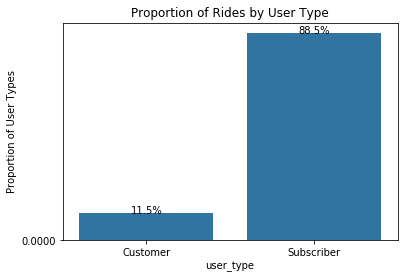

In [7]:
sb.countplot(data=clean,x= 'user_type');
n_obs = clean.shape[0]
max_count = clean.user_type.value_counts().max()
max_prop = max_count/n_obs
tick_props= np.arange(0, max_prop, 1)
tick_names = ['{:0.4f}'.format(v) for v in tick_props]
base_color = sb.color_palette()[0]
g = sb.countplot(data=clean, x='user_type', color=base_color)
plt.yticks(tick_props*n_obs, tick_names)
plt.ylabel('Proportion of User Types')
locs, labels = plt.xticks()
user_counts = clean['user_type'].value_counts()
plt.title('Proportion of Rides by User Type')
## add labels
for loc, label in zip(locs, labels):

    count = user_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_obs)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha='center',color = 'black')

## Hourly Distribution of GoBike Rides

The hour variable follows a pretty strong bimodal trend. We see peaks around the start and end of the workday, 8 and 5, respectively, with very few rides in the early morning and late at night. Looking at time of day alone, we'd probably be able to predict ride frequency pretty well based on time of day alone.

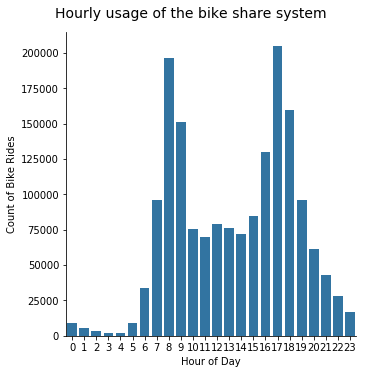

In [8]:
g = sb.catplot(data=clean, x='hour', kind='count', color = base_color);
g.set_axis_labels("Hour of Day", "Count of Bike Rides");
g.fig.suptitle('Hourly usage of the bike share system', y=1.03, fontsize=14);

##  Distribution of Rides by Gender

We can see from this that male subscribers are accounting for the vast majority of all rides. However, since this is followed by female subscribers and not male customers, we can assert that subscriber status is a likely stronger predictor of ride frequency than gender is. So far, membership, hours and gender are looking like our biggest predictors of frequent riders. 

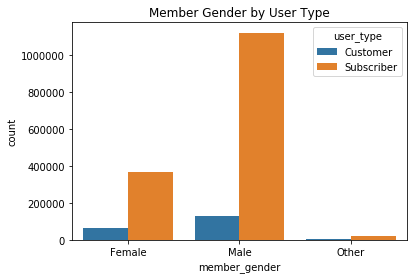

In [9]:
sb.countplot(data=clean, x='member_gender', hue='user_type');
plt.title('Member Gender by User Type');

## Daily Distribution Among User Types

From this we can see a clear relationship between user type and weekday distribution. Customers have less fixed riding habits-- they have a fairly even spread across all days of the week, with peaks on weekends. This is a stark difference from the Subscriber group-- their ride rates plummet on weekends and are consistently very high on weekdays. To sum it up, Customers appear to be a fairly unpredictable, mixed-bag kind of group (some commuters, many recreational users), while Subscribers are nearly all commuters and their use is highly predictable.

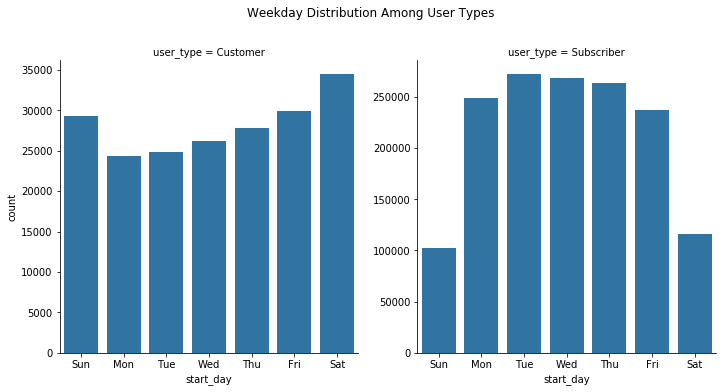

In [10]:
clean.start_day = pd.Categorical(clean['start_day'], categories = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], ordered = True)
sb.catplot(data=clean, x='start_day', col='user_type', kind='count', sharey=False, color=base_color);
plt.suptitle('Weekday Distribution Among User Types', y=1.08);

## Bike Share for All Program Membership Across Genders

It's clear from these plots that the membership rates between men and women in the Bike Share program are nearly identical, but those who identify as an "Other" gender are much more likely (to be exact, 40% more likely) to be enrolled in the program.

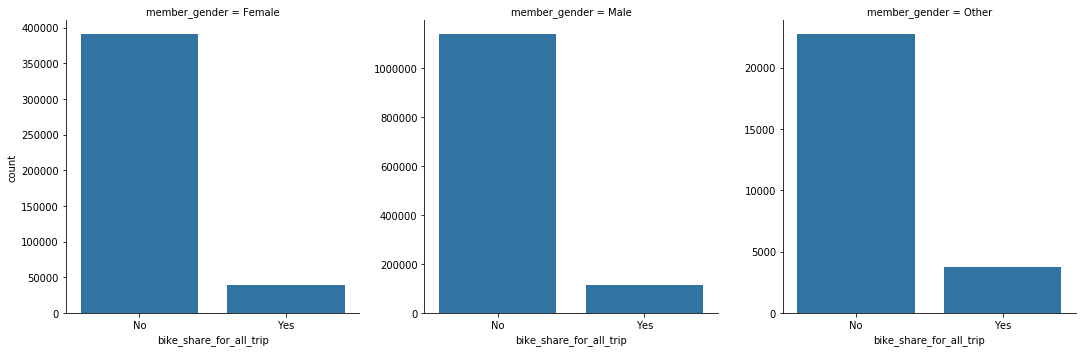

In [11]:
sb.catplot(data=clean, x='bike_share_for_all_trip', col='member_gender', kind='count', sharey=False, color = base_color);

## Hourly Usage Throughout the Week by User Type

For those with a membership use is frequent and consistent, with peaks during the morning and evening work-rush. For customers, it's much less so. Use is much more scattered throughout the week, plus customers are much more likely than subscribers to take weekend trips. Customers are similar to subscribers in that they tend to ride more during the evening hours (~5) during the weekdays, but the amount of trips is far, far less. This makes it clear that our Customer group is segmented in itself, but the Subscriber group is homogeneous.

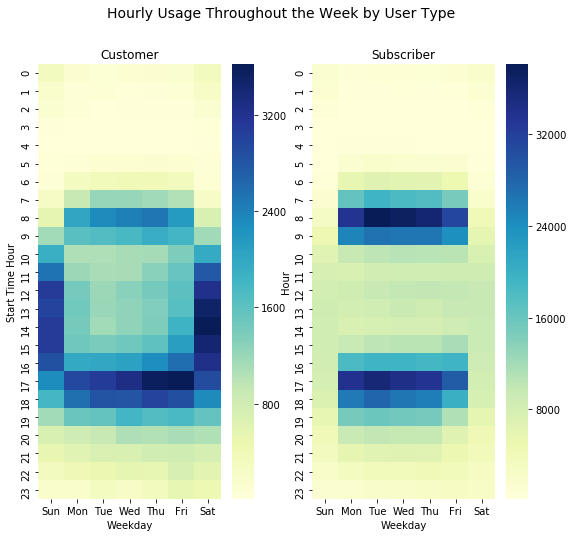

In [12]:
plt.figure(figsize=(9,8))
plt.suptitle('Hourly Usage Throughout the Week by User Type', fontsize=14)

## heatmap for customers
plt.subplot(1,2,1)
df_customer = clean.query('user_type == "Customer"').groupby(["hour", "start_day"])["bike_id"].size().reset_index()
df_customer = df_customer.pivot("hour", "start_day", "bike_id")
sb.heatmap(df_customer, cmap="YlGnBu")

plt.title("Customer", y=1.015);
plt.xlabel('Weekday');
plt.ylabel('Start Time Hour');

## heatmap for subscribers
plt.subplot(1,2,2)
df_subscriber = clean.query('user_type =="Subscriber"').groupby(['hour', 'start_day'])['bike_id'].size().reset_index()
df_subscriber = df_subscriber.pivot('hour', 'start_day', 'bike_id')
sb.heatmap(df_subscriber, cmap="YlGnBu")

plt.title('Subscriber', y=1.015);
plt.xlabel('Weekday');
plt.ylabel('Hour');

## Hourly Usage Throughout the Week by Bike Share Program Membership

When subscriber type is further broken down, you can see that there are actually two distinct member segments. The members who aren't part of the Bike Share program are characterized by weekday trips to and from work. They ride on the same days and at the same times. This group's hours are highly predictable, which makes me think it's made up of primarily salaried, or full-time, workers. The Bike Share members are different, though. Their schedules are all over the place, with some consistency occurring during the weekdays around 5pm. Since the Bike Share program enrolls members on a need-basis, we might be right to assume these are not your average 9-5ers. This would explain the variability in the ride times and days-- hourly workers' schedules are often in flux/inconsistent. 

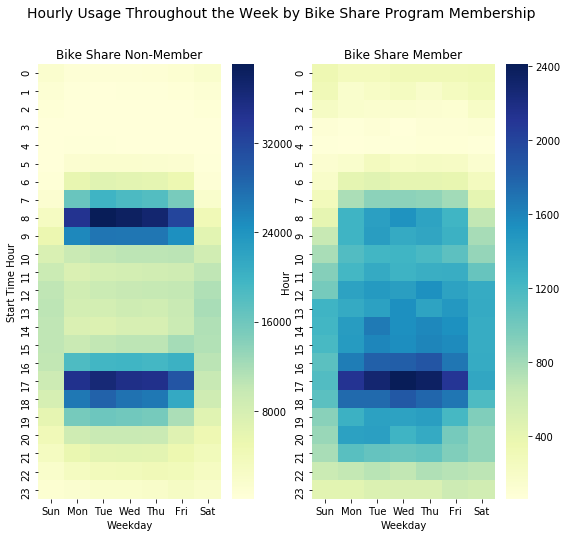

In [13]:
plt.figure(figsize=(9,8))
plt.suptitle('Hourly Usage Throughout the Week by Bike Share Program Membership', fontsize=14);

## heatmap for customers
plt.subplot(1,2,1)
df_bsfa_no = clean.query('bike_share_for_all_trip == "No"').groupby(["hour", "start_day"])["bike_id"].size().reset_index()
df_bsfa_no = df_bsfa_no.pivot("hour", "start_day", "bike_id")
sb.heatmap(df_bsfa_no, cmap="YlGnBu")

plt.title("Bike Share Non-Member", y=1.015);
plt.xlabel('Weekday');
plt.ylabel('Start Time Hour');

## heatmap for subscribers
plt.subplot(1,2,2)
df_bsfa_yes = clean.query('bike_share_for_all_trip =="Yes"').groupby(['hour', 'start_day'])['bike_id'].size().reset_index()
df_bsfa_yes = df_bsfa_yes.pivot('hour', 'start_day', 'bike_id')
sb.heatmap(df_bsfa_yes, cmap="YlGnBu")

plt.title('Bike Share Member', y=1.015);
plt.xlabel('Weekday');
plt.ylabel('Hour');

In [14]:
# jupyter nbconvert slide_deck.ipynb --to slides --post serve --template output_toggle